<a href="https://colab.research.google.com/github/Colsai/scott_data606/blob/main/Topic_Modeling_Final/Topic_Modeling_Workplans_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HHS OIG Workplan** Topic Modeling (Step 1)
## Initial Test of LDA Modeling
*Description: A look through the current OIG work projects and group them using LDA and BertTopic.*

## What is a work plan?
- An OIG work plan is a commitment to a specific analysis to be done on an area of interest. These are general plans, and provide a high-level overview of the intended work. Some work plans are very short, others include several paragraphs for scope and detail. *For example:*

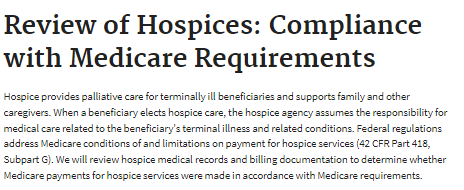

## Scope of Initial Notebook
This notebook will establish two types of topic modeling strategies, then analyze the topics that the model has yielded.

## Specific Questions on Work Plan Projects
1) What does OIG cite as major focus areas (as topics)?  
- *How can we group OIG's work projects and products by topic?*

2) Do those topics line up with major focus areas that HHS OIG designates as their priority outcomes/ultimate goals? (from: https://oig.hhs.gov/documents/root/7/OIG-Strategic-Plan-2020-2025.pdf)


*HHS OIG: Outlined Goals and Priorities*
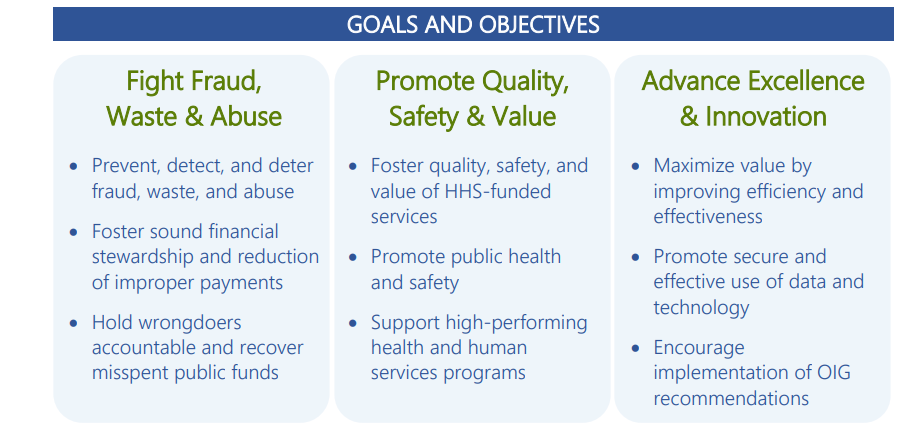

## Work Plan Topic Models Used:
1) **Latent Dirichilet Allocation (LDA) Model**  
2) **BerTopic Model**


In [ ]:
from IPython.display import clear_output

In [ ]:
#Install missing packages
!pip install pyLDAvis
!pip install bertopic
!pip install bertopic[visualization]
!python -m spacy download en_core_web_md -qq
clear_output()

In [ ]:
###########################
# Import Packages         #
###########################
import pandas as pd
import sklearn
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim_models
import en_core_web_md
import gensim
import random
import pyLDAvis
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.test.utils import datapath
import warnings

warnings.filterwarnings('ignore')

# Set options for specific packages
nltk.download(['punkt', 
               'stopwords',
               'wordnet',
               'omw-1.4'])

# Visualise inside a notebook
pyLDAvis.enable_notebook()

sns.set()

clear_output()

In [ ]:
###########################
# Load CSVs (Github)      #
###########################
workplan_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_workplan_summaries.csv?raw=true")

#Drop typo column
workplan_df.drop(columns = 'Office of Evaluation and Inspections', 
                 inplace = True)

reports_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_OIG_Reports.csv?raw=true")

In [ ]:
#Method to save LDA model to disk
'''
def save_model(path = '/content/drive/MyDrive/DATA_606/lda_model', 
               model = Lda_model):
    temp_file = datapath([path])
    model.save(temp_file)

# Load a potentially pretrained model from disk.
def load_model(path = ''):
    saved_model = LdaModel.load(path)
    return saved_model
'''

clear_output()

## Latent Dirichlet Allocation (LDA) Model
Topic model by cleaning text and running it through an LDA model.

In [ ]:
workplan_df.head()

,Announced or Revised,Agency,Title,Component,Report Number(s),Expected Issue Date (FY),Website_Link,Summary
0,Completed,Administration for Children and Families,States' Accuracy of Reporting TANF Spending In...,Office of Audit Services,A-02-17-02005; W-00-17-25100,2021,https://oig.hhs.gov/reports-and-publications/w...,The Temporary Assistance for Needy Families (T...
1,Completed,Administration for Children and Families,Head Start: Review of Single Audit Findings an...,Office of Audit Services,"A-02-16-02009, A-09-16-01004, A-06-17-07003;...",2018,https://oig.hhs.gov/reports-and-publications/w...,Effective for awards made on or after December...
2,Completed,Administration for Children and Families,Unaccompanied Children Program Grantee Reviews,Office of Audit Services,A-02-16-02013; A-04-16-03566; A-02-16-02007;...,2020,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
3,Nov-16,Administration for Children and Families,Recommendation Follow-Up: Office of Refugee Re...,Office of Evaluation and Inspections,OEI-09-16-00260,2017,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
4,October 2020,Administration for Children and Families,ACF Oversight of Guardian Ad Litem Requirement...,Office of Evaluation and Inspections,OEI-12-16-00120,2022,https://oig.hhs.gov/reports-and-publications/w...,As a condition of receiving Child Abuse Preven...


## LDA Step 1: Parse, Clean, and Tokenize text
- Set stopwords, add custom stopwords
- Remove Punctuation, tokenize and stem data
- Set series of lists of tokens and count of tokens

In [ ]:
###########################
# Text Cleaning           #
###########################
from nltk.stem import RegexpStemmer

stopwords = nltk.corpus.stopwords.words('english')

#Add Stopwords (Add additional stopwords that were high-frequency)
stopwords.extend(['on',
                  'or', 
                  'to', 
                  'a', 
                  'as', 
                  'of', 
                  'for',
                  'this', 
                  'by', 
                  's',])

#Extend for specific/frequent hhs-related words
stopwords.extend(['oig',
                  'hhs',
                  'amp',
                  'asp'])

##############################
# Tokenize and Stemmer       #
##############################
#Set tokenizer as regex tokenizer to remove punctuation
regex_tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in workplan_df["Summary"]]

tokenized_sums = [[i for i in regex_tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
workplan_df["summary_tokenized"] = tokenized_stemmed_sums

workplan_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

## Model Score (Coherence)
- U_mass coherence score is a score of the frequency at which two words appear together. 
- Score Coherence of Model - u_mass coherence score
- (Consider also c_v, other scores)
See: https://www.baeldung.com/cs/topic-modeling-coherence-score

In [ ]:
#LDA Model Coherence Score
cm = CoherenceModel(model=lda_model, 
                    corpus=corpus, 
                    coherence="u_mass")

coherence = cm.get_coherence()  # get coherence value

print(coherence)

-2.121762826450422


In [ ]:
#########################
# Test Number of Topics #
#########################
lda_umass_scores = []

for topic_num in range(1,30,4):
    #LDA model parameters
    lda_model = LdaMulticore(corpus=corpus, 
                            id2word=dictionary, 
                            iterations=200, 
                            num_topics=topic_num,
                            workers = None, 
                            passes=10)

    #LDA Model Coherence Score
    cm = CoherenceModel(model=lda_model, 
                        corpus=corpus, 
                        coherence="u_mass")
    
    # get coherence value
    coherence = cm.get_coherence()  
    print(f"Topics:{topic_num}, Coherence = {coherence}")
    
    #Save Coherence Values
    lda_umass_scores.append([topic_num, coherence])

Topics:1, Coherence = -1.390882183853568
Topics:5, Coherence = -2.611120360695908
Topics:9, Coherence = -2.3427704660933966
Topics:13, Coherence = -2.563246200902876
Topics:17, Coherence = -2.1348252619732517
Topics:21, Coherence = -2.5830725525716907
Topics:25, Coherence = -2.3968915483701183
Topics:29, Coherence = -2.3926541741177565


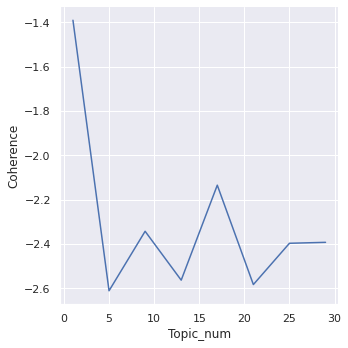

In [ ]:
#Coherence Score Graphing
coherence_scores = pd.DataFrame(lda_umass_scores, 
                                columns = ['Topic_num',
                                           'Coherence'])

sns.relplot(data = coherence_scores, 
            kind="line",
            x = 'Topic_num', 
            y= 'Coherence')

In [ ]:
###############################
# LDA Data: Run LDA           #
###############################

dictionary = Dictionary(workplan_df["summary_tokenized"])

#Filter extreme token values (no tokens below 5, no tokens in over 50% of documents)
dictionary.filter_extremes(no_below=5, 
                           no_above=0.5, 
                           keep_n=1000)

#Corpus from doc2bow
corpus = [dictionary.doc2bow(doc) for 
          doc in workplan_df["summary_tokenized"]]

#lda model parameters
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=200, 
                         num_topics=17,
                         workers = 8, 
                         passes=5)

### Run LDA
Using the cleaned data, run the LDA model on the summary tokens.
- Set dictionary as the tokens,
- Filter Extremes
- Set Corpus with Doc2bow
- Create LDA Model with Parameters

### Check Summaries
Let's take a look at how well the text parsing and tokenization worked

In [ ]:
#Sample Summaries
sample_item = workplan_df.sample(1)

print(sample_item["Summary"].iloc[0])

print(sample_item["summary_tokenized"].iloc[0])

Cost principles for Educational Institutions at 45 CFR Part 75 are used in determining the allowable costs of work performed by colleges and universities under sponsored agreements.  The principles will also be used in determining the costs of work performed by such institutions under subgrants, cost-reimbursement subcontracts, and other awards made to them under sponsored agreements.  We will assess colleges' and universities' controls over the subcontracting of National Institutes of Health grant and contract work. Specifically, we will determine whether colleges and universities effectively monitor the services subcontracted to other organizations and ensure that Federal funds are spent on allowable goods and services in compliance with selected cost principles and the terms and conditions of the grants and subcontracts. We will conduct reviews at selected organizations based on the dollar value of Federal grants received and on input from National Institutes of Health.
['cost', 'pr

### LDA: Visualize and View Topics
*Use PyLDAvis to generate a visualization of the model*

#### Side Note: We may encounter the word 'Part' often in the data.

#### What are the 'parts' of medicare?
- https://www.medicareinteractive.org/get-answers/medicare-basics/medicare-coverage-overview/original-medicare
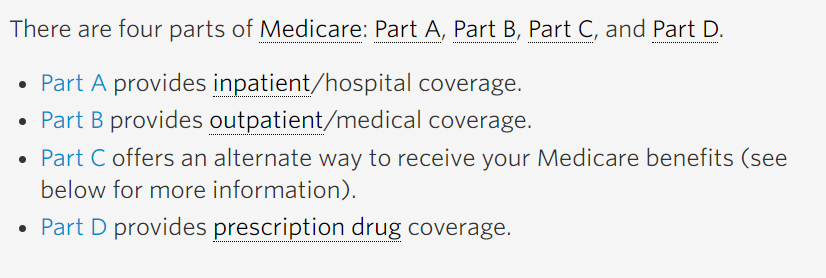

In [ ]:
#Visualize the model with pyLDAvis
lda_model_visualize = pyLDAvis.gensim_models.prepare(lda_model,
                                                     corpus = corpus, 
                                                     dictionary = dictionary)
lda_model_visualize

#Give context and explanation for the lambda relevance metric

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
20    -0.094832 -0.025741       1        1  6.678643
8      0.082457  0.028210       2        1  6.336952
6     -0.142514 -0.003395       3        1  5.608569
26    -0.217526  0.097243       4        1  5.056852
22    -0.128182 -0.063718       5        1  4.769002
19    -0.058129 -0.132701       6        1  4.685652
21     0.150865  0.080508       7        1  4.602002
1      0.001868  0.081047       8        1  4.578953
17     0.145964 -0.008623       9        1  4.490569
2     -0.020385 -0.080526      10        1  4.287916
13    -0.036593 -0.084991      11        1  4.022546
16    -0.031648  0.044863      12        1  3.868847
28     0.175811  0.008572      13        1  3.599716
25     0.222090  0.060617      14        1  3.571492
4     -0.061493 -0.117336      15        1  3.351281
3     -0.072888  0.018066      16        1  3.317449
5     -0.096161  0.089422      17        1  3.224608
0      0.162692 -0.017464      18        1  2.979219
18     0.082342 -0.005213      19        1  2.960324
15    -0.141370  0.064334      20        1  2.519060
11    -0.047954 -0.169065      21        1  2.505823
27    -0.195363 -0.095885      22        1  2.392355
12     0.118562 -0.093433      23        1  2.295777
23     0.240162  0.003834      24        1  2.016326
24    -0.095603  0.325851      25        1  1.769002
9      0.040631 -0.001626      26        1  1.569299
7     -0.000569 -0.098240      27        1  1.326162
10     0.026434  0.030000      28        1  1.193091
14    -0.008669  0.065391      29        1  0.422512, topic_info=           Term        Freq       Total Category  logprob  loglift
161        drug  435.000000  435.000000  Default  30.0000  30.0000
41        state  743.000000  743.000000  Default  29.0000  29.0000
235    medicare  940.000000  940.000000  Default  28.0000  28.0000
347    hospital  302.000000  302.000000  Default  27.0000  27.0000
211     payment  629.000000  629.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
235    medicare    4.540323  940.156066  Topic29  -3.7750   0.1337
109        also    2.216358  217.490715  Topic29  -4.4921   0.8804
518      system    2.064745  156.857038  Topic29  -4.5630   1.1364
242     support    1.976477  133.963051  Topic29  -4.6066   1.2505
135  compliance    1.934673   99.873028  Topic29  -4.6280   1.5227

[1557 rows x 6 columns], token_table=      Topic      Freq Term
term                      
46        3  0.115527  000
46        4  0.161738  000
46        5  0.046211  000
46        6  0.485214  000
46       11  0.023105  000
...     ...       ...  ...
650      10  0.049806    ½
650      12  0.398447    ½
650      16  0.199223    ½
650      20  0.049806    ½
650      28  0.049806    ½

[6563 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 9, 7, 27, 23, 20, 22, 2, 18, 3, 14, 17, 29, 26, 5, 4, 6, 1, 19, 16, 12, 28, 13, 24, 25, 10, 8, 11, 15])

## Notes
- Relevance is calculated as the chance of the term being present within the topic.

In [ ]:
#Looking at a specific topic within the models
for idx, topic in lda_model.print_topics():
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 14 
Words: 0.076*"rehabilitation" + 0.046*"federal" + 0.040*"requirement" + 0.030*"program" + 0.028*"health" + 0.027*"cm" + 0.027*"plann" + 0.024*"ensure" + 0.023*"medicare" + 0.022*"accordance"
Topic: 12 
Words: 0.045*"hospital" + 0.039*"care" + 0.033*"medicare" + 0.023*"transaction" + 0.022*"patient" + 0.021*"event" + 0.016*"information" + 0.015*"beneficiar" + 0.011*"harm" + 0.011*"describe"
Topic: 23 
Words: 0.106*"hospital" + 0.065*"medicare" + 0.042*"transfer" + 0.039*"payment" + 0.036*"inpatient" + 0.030*"acute" + 0.030*"care" + 0.022*"discharge" + 0.021*"paid" + 0.017*"post"
Topic: 3 
Words: 0.036*"program" + 0.029*"check" + 0.023*"background" + 0.019*"state" + 0.018*"care" + 0.017*"grant" + 0.015*"agency" + 0.015*"national" + 0.014*"provider" + 0.013*"year"
Topic: 27 
Words: 0.057*"response" + 0.055*"emergency" + 0.053*"preparednes" + 0.039*"public" + 0.030*"health" + 0.026*"disease" + 0.022*"disaster" + 0.021*"aspr" + 0.020*"emergenc" + 0.019*"covid"
Topic: 5 
Words: 0.

In [ ]:
#Eye Test (Classification Test)
n = random.randint(0,len(workplan_df))

print(workplan_df.iloc[n]['Summary'], end = '')

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

When a State recovers a prior expenditure, it must refund the Federal share by reporting the recovery to Centers for Medicare &amp; Medicaid Services at the FMAP used to calculate the amount it had originally received (SSA § 1903(d)(2); Centers for Medicare &amp; Medicaid Services State Medicaid Manual, § 2500.6(B)).  In its final rule (81 Fed. Reg. 27498 (May 6, 2016)), Centers for Medicare &amp; Medicaid Services encouraged States to adopt provisions in contracts with managed care plans that would require remittances from the MCOs if a minimum medical loss ratio is not met.  A medical loss ratio is a tool that can help ensure that the majority of capitated payments are used to deliver services to beneficiaries.  Prior OIG reviews found that some States have adopted such remittance provisions.  We will review States and managed care plans with contract provisions that require remittances from managed care plans if a minimum percentage of total costs to be expended for medical services

-- Plot here for u_mass coherence based on topics

## Step 1: Clean data before model usage
- Add lemmatization
- Set documents for BERTopic as 'docs'
- Use vectorizer_model and set parameters

In [ ]:
#CountVectorizer is used here for removing stopwords after processing
from sklearn.feature_extraction.text import CountVectorizer   
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

#Remove Stopwords through vectorizer_model
from bertopic import BERTopic

#Lemmatizer for cleaning text
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

#Set docs as workplan summaries
docs = workplan_df["Summary"].reset_index(drop = True)

#Vectorizer model for adding in Stopwords and Lemmatization
vectorizer_model = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words=stopwords,
                                   tokenizer=LemmaTokenizer())

## Step 2: Run BERTopic Model
- Use vectorizer model
- Fit and return topics and probabilites

In [ ]:
#Bert Model- use countvectorizer, allow n-grams of size 1 or 2
bert_model = BERTopic(vectorizer_model=vectorizer_model, 
                      top_n_words = 10,
                      n_gram_range=(1, 2),
                      language = 'english')

#Fit/Transform Topics and Probabilities
topics, probabilities = bert_model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
#Display Topics
bert_model.get_topic_info()

,Topic,Count,Name
0,-1,81,-1_medicare_data_medicaid_care
1,0,96,0_medicare_payment_service_hospital
2,1,76,1_state_medicaid_care_service
3,2,71,2_drug_part_medicare_price
4,3,42,3_opioid_treatment_overdose_abuse
5,4,40,4_financial_audit_financial statement_statement
6,5,33,5_emergency_preparedness_covid19_home
7,6,31,6_child_state_family_program
8,7,26,7_health_fund_pepfar_cdc
9,8,22,8_nih_institute_research_national institute


Display depth of topics:

In [ ]:
#Display Topics (top-5)
pd.DataFrame(bert_model.get_topics()).T.loc[0::]

,0,1,2,3,4,5,6,7,8,9
0,"(medicare, 0.042090344730020234)","(payment, 0.033939152944262245)","(service, 0.03030458560788755)","(hospital, 0.03007522817559155)","(claim, 0.020183759471532763)","(inpatient, 0.01899950052138915)","(physician, 0.015764347541124303)","(beneficiary, 0.015757011498290664)","(determine, 0.015433093797006001)","(part, 0.014564066273950392)"
1,"(state, 0.049802523311221945)","(medicaid, 0.04337642986186871)","(care, 0.027994665781938533)","(service, 0.02611444976814564)","(federal, 0.02248291321595198)","(managed care, 0.018357800639469738)","(managed, 0.01804335229901784)","(payment, 0.01655044810708966)","(health, 0.01583200845793273)","(provider, 0.01566590437706969)"
2,"(drug, 0.06369883924258359)","(part, 0.03812774836986338)","(medicare, 0.030602327870288226)","(price, 0.027424800940113094)","(manufacturer, 0.026721773040556982)","(rebate, 0.02408926827347666)","(amount, 0.020445151228526647)","(beneficiary, 0.0191464975826811)","(medicare part, 0.017212391541007652)","(part b, 0.016539708228363058)"
3,"(opioid, 0.066165610530308)","(treatment, 0.03214299489252147)","(overdose, 0.031793539142682764)","(abuse, 0.026850246672857826)","(opioids, 0.025408098344522286)","(substance, 0.025028956346367287)","(death, 0.0236179277658215)","(disorder, 0.022900919965713466)","(use, 0.022664026165849203)","(opioid use, 0.020807400696295844)"
4,"(financial, 0.045130705274713794)","(audit, 0.034450722120791914)","(financial statement, 0.03230959821232608)","(statement, 0.03216354585751252)","(agency, 0.029865788312940726)","(federal, 0.02977612199048833)","(act, 0.021257509607120723)","(review, 0.01954435506059216)","(improper, 0.019496744681990735)","(statement audit, 0.018411907197833522)"
5,"(emergency, 0.03770529904371224)","(preparedness, 0.03693509661998942)","(covid19, 0.03521410075726014)","(home, 0.03495765961010839)","(nursing home, 0.03386789561663051)","(nursing, 0.0316876440413466)","(response, 0.028402423794867102)","(disease, 0.02338258535581347)","(emergency preparedness, 0.02297078560353224)","(infection, 0.02163807777985505)"
6,"(child, 0.05319885408773997)","(state, 0.04815423222112997)","(family, 0.03502862718710022)","(program, 0.03010752224071713)","(foster, 0.026444654289489552)","(childcare, 0.02624318027757601)","(check, 0.02590010275495179)","(care, 0.024897903356875892)","(foster care, 0.024709980868882053)","(federal, 0.021954398101922228)"
7,"(health, 0.034646491086857086)","(fund, 0.030417493300422246)","(pepfar, 0.03010047383433167)","(cdc, 0.028022678341899705)","(provider, 0.024191485505906222)","(relief, 0.021278947588390967)","(pepfar fund, 0.0198392582852441)","(covid19, 0.019090991807519702)","(control, 0.018269338599914222)","(health center, 0.018005263344023126)"
8,"(nih, 0.09596175382364408)","(institute, 0.04852842544816443)","(research, 0.043499836568507776)","(national institute, 0.03430611398959772)","(grant, 0.0320216034372144)","(grantee, 0.029996747716043864)","(institute health, 0.029264235525467294)","(national, 0.02798472255736402)","(foreign, 0.02560620608478388)","(health, 0.025243971491972193)"
9,"(child, 0.07733148051304142)","(orr, 0.07715369026859994)","(unaccompanied, 0.05111386221127476)","(refugee, 0.03972099789460259)","(unaccompanied child, 0.03972099789460259)","(facility, 0.0364759405910484)","(resettlement, 0.02966253237517318)","(refugee resettlement, 0.02966253237517318)","(resettlement orr, 0.028492253311849687)","(office refugee, 0.028492253311849687)"


In [ ]:
#Eye Test:
random_doc = random.randint(0,len(docs))
print(docs[random_doc])

model_prediction = bert_model.transform(docs[random_doc])
print(model_prediction)

bert_model.get_topic(topic=model_prediction[0][0])

HHS is responsible for implementing appropriate controls in Indian Health Service (IHS) hospitals to track the disbursement of prescription drugs (including opioids and other Schedule II drugs) in accordance with Federal security requirements.  Prior OIG audits reported that HHS lacks sufficient security controls, which potentially impact abuse of prescription drugs.  We will determine whether HHS applications that track the disbursement of prescription drugs meet Federal information security standards.  We will focus on access and physical controls.  For selected IHS hospitals, we will review security controls and use OIG's automated assessment tools to assess the security of the networks and web-facing applications.
([11], array([0.90993166]))


[('security', 0.04961245804290411),
 ('gda', 0.028482121437138512),
 ('information', 0.027756890282755173),
 ('cybersecurity', 0.02767562068562641),
 ('data', 0.025207293636773445),
 ('federal', 0.025075789391367856),
 ('opdivs', 0.024291244776095525),
 ('determine', 0.02375092116019022),
 ('cloud', 0.023577576059499925),
 ('fisma', 0.02104511440704891)]

### BERTopic Visualizations
- Visualizations of topics

In [ ]:
bert_model.visualize_barchart(n_words = 7,
                              width=400, 
                              height=400,
                              top_n_topics = 10)

In [ ]:
bert_model.visualize_topics()

In [ ]:
#What topics are grouped?
bert_model.visualize_heatmap()

## Comparing the two models:

In [ ]:
#Comparison between models
n = random.randint(0,len(workplan_df))

print(workplan_df.iloc[n]['Summary'])

#############
#LDA Model  #
#############
print("***LDA Model***")

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print(score, lda_model.print_topic(index, 10))

#############
#Bert Model #
#############
print("\n***Bert Model***")
model_prediction = bert_model.transform(docs[n])

print(f"BERT: {model_prediction}")

bert_model.get_topic(topic=model_prediction[0][0])

As of July 1, 2011, Federal payments to States are prohibited for any amounts expended for providing medical assistance for health-care-acquired conditions (SSA §1903 and Patient Protection and Affordable Care Act §2702).  Federal regulations prohibit Medicaid payments by States for services related to health-care-acquired conditions and for provider preventable conditions as defined by Centers for Medicare &amp; Medicaid Services or included in the Medicaid State Plan  (42 CFR §447.26).  We will determine whether selected States made Medicaid payments for hospital care associated with health-care-acquired conditions and provider preventable conditions and quantify the amount of Medicaid payments for such conditions.
***LDA Model***
0.4952912 0.099*"medicaid" + 0.084*"state" + 0.042*"care" + 0.033*"payment" + 0.030*"federal" + 0.029*"mco" + 0.025*"program" + 0.025*"managed" + 0.013*"provider" + 0.012*"organization"
0.20730999 0.068*"state" + 0.032*"care" + 0.028*"medicaid" + 0.028*"hea

[('state', 0.049802523311221945),
 ('medicaid', 0.04337642986186871),
 ('care', 0.027994665781938533),
 ('service', 0.02611444976814564),
 ('federal', 0.02248291321595198),
 ('managed care', 0.018357800639469738),
 ('managed', 0.01804335229901784),
 ('payment', 0.01655044810708966),
 ('health', 0.01583200845793273),
 ('provider', 0.01566590437706969)]

In [ ]:
model_prediction

([1], array([0.72878756]))

## BERTopic Topic Modeling
*BERTopic is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. BERTopic supports guided, (semi-) supervised, and dynamic topic modeling. (MaartgenGr)* 

#### Repo
- https://github.com/MaartenGr/BERTopic

#### Papers
- https://arxiv.org/pdf/2203.05794.pdf
- https://arxiv.org/pdf/2107.02173.pdf

- https://hackernoon.com/nlp-tutorial-topic-modeling-in-python-with-bertopic-372w35l9

#### On removing stopwords:
- https://stackoverflow.com/questions/68127754/removal-of-stop-words-and-stemming-lemmatization-for-bertopic#:~:text=In%20conclusion%2C%20the%20BERTTopic%20does,both%20processing%20time%20and%20results.

#### On Lemmatization
- https://github.com/MaartenGr/BERTopic/issues/286

### References
Link: https://zbib.org/d7adbbe5aea84033ae5c3d470692299b
  
  
### Works Cited
Kapadia, Shashank. “Topic Modeling in Python: Latent Dirichlet Allocation (LDA).” Medium, 29 Dec. 2020, https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0.

Kelechava, Marc. “Using LDA Topic Models as a Classification Model Input.” Medium, 6 Aug. 2020, https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28.

Khalid, Irfan Alghani. “Implement Your Topic Modeling Using The BERTopic Library.” Medium, 25 Jan. 2022, https://towardsdatascience.com/implement-your-topic-modeling-using-the-bertopic-library-d6708baa78fe.

“PyLDAvis: Topic Modelling Exploration Tool That Every NLP Data Scientist Should Know.” Neptune.Ai, 16 Nov. 2020, https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know.

Yadav, Kajal. “The Complete Practical Guide to Topic Modelling.” Medium, 22 Jan. 2022, https://towardsdatascience.com/topic-modelling-f51e5ebfb40a.
